In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_32649/2647508162.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import templates
import fields
import spectrum

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Generating templates of anisotropic shifts in $dN/dz$

We can generate a mock template providing the following inputs:
- `sigma_of_shift` = float. Standard deviation of the shifts across the template
- `nside` = int. Defines the pixelization
- `alpha` = float. Power law index for the perturbation Cls
- `lmax_pert` = int. lmax of the Cls

In [4]:
sigma_of_shift = 0.003
nside = 128
alpha = -2
lmax_pert = 100

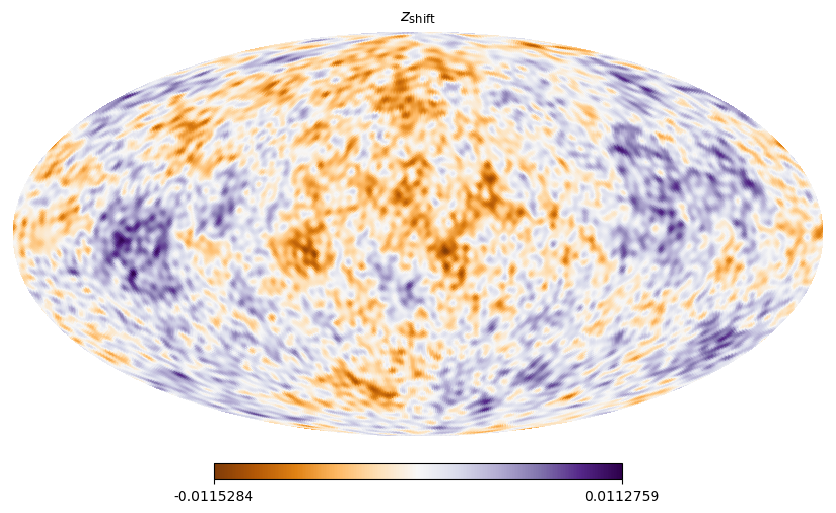

In [5]:
test_mock_template = templates.MockTemplate(sigma_of_shift, nside, alpha, lmax_pert)
test_mock_template.show()

Alternatively, if we already have a template characterizing the shifts in either the mean redshift or width of our $dN/dz$ in every pixel of some healpix pixelization, we can use the CustomTemplate class as follows:

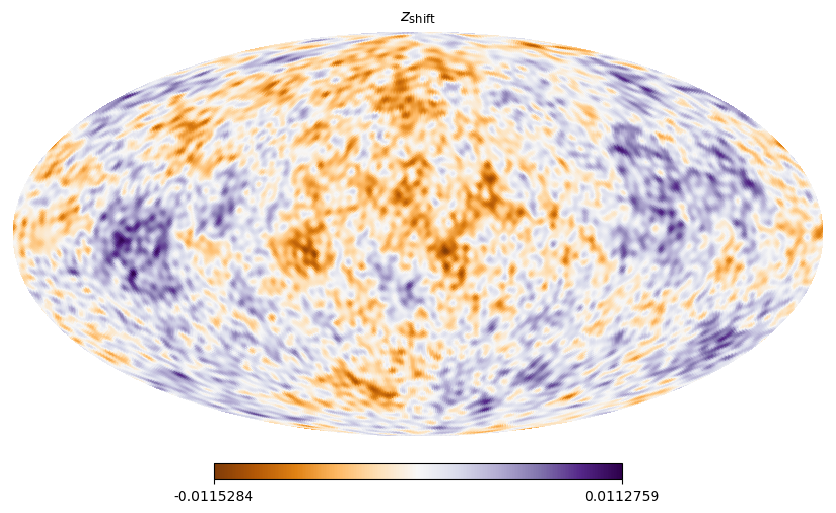

In [6]:
myshifts_template = test_mock_template.map

test_custom_template = templates.CustomTemplate(myshifts_template)
test_custom_template.show()

# Constructing `field` objects

We first need to introduce a `grid` object that will define the discrete redshifts we will be working with as well as the healpix pixelization (this will need to match our anisotropy templates)

In [7]:
n_samples_of_chi = 2**8 # (a power of 2). Number of samples in chi
sigma = 0.06 # Standard deviation of the fiducial dndz
z_mean = 0.59 # Central redshift of the fiducial dndz
z_max_int = z_mean + 10*sigma # Higher end of the integration range in redshift

my_grid = fields.grid(nside, n_samples_of_chi, z_max_int=z_max_int)

We'll now use one of the templates above to initialize objects corresponding to observed fields subject to projection anisotropy

In [29]:
#UNIT-redmagic bias parameters from 2101.11014
#         b1,    b2,    bs2,   bnabla2, SN
bvec = [0.786, 0.583, -0.406, -0.512, 1755]

gal_overdensity = fields.GalDelta(my_grid, sigma, z_mean, bvec, template_zmean_shifts=test_mock_template)

In [70]:
gal_kappa = fields.GalShear(my_grid, sigma, z_mean, template_zmean_shifts=test_mock_template)

Notice that these inherit the properties of the `Template` around which it is constructed, for example:

In [71]:
gal_overdensity.template_zmean_shifts.__dict__

{'lmax_pert': 100,
 'alpha': -2,
 'map': array([ 2.49209551e-04, -3.49900581e-05, -6.24269550e-04, ...,
         3.05599748e-03,  2.67497101e-03,  2.68053047e-03]),
 'npix': 196608,
 'nside': 128,
 'sigma_of_shift': 0.003}

# Define a `Spec` object

In [72]:
cs_auto = spectrum.Spec(gal_kappa)
gc_auto = spectrum.Spec(gal_overdensity)
gc_x_cs = spectrum.Spec(gal_kappa, gal_overdensity)

These already have some interesting properties. For example, the covariance in each redshift slice will let us predict the biases on small angular scales

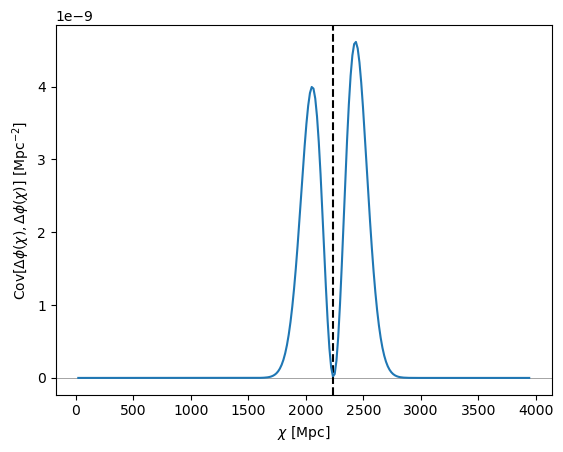

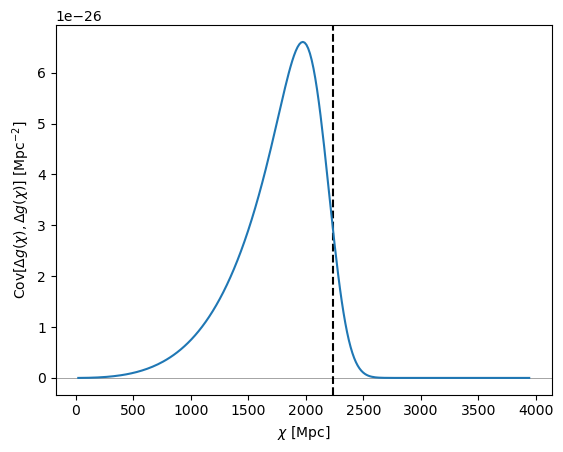

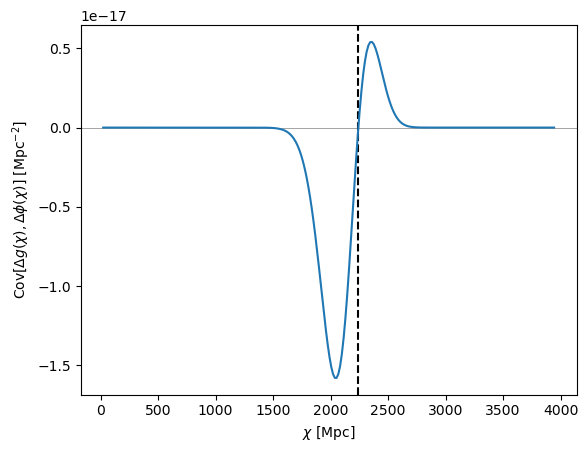

In [73]:
gc_auto.plot_DeltaP_covariance()
cs_auto.plot_DeltaP_covariance()
gc_x_cs.plot_DeltaP_covariance()

These objects also contain the fiducial projection kernels

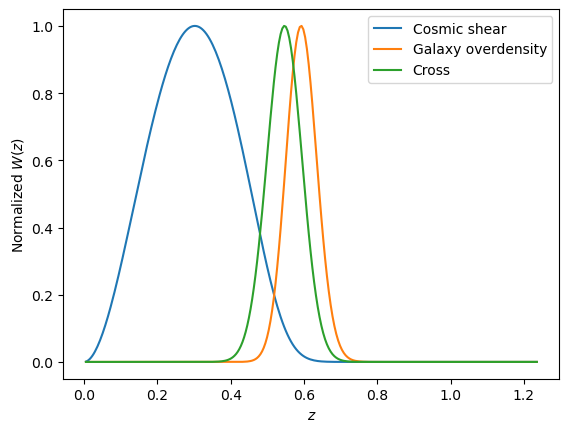

In [74]:
plt.plot(my_grid.z_array[0,:], cs_auto.kernel(my_grid.chi_array) / np.max(cs_auto.kernel(my_grid.chi_array)), label=r'Cosmic shear')
plt.plot(my_grid.z_array[0,:], gc_auto.kernel(my_grid.chi_array) / np.max(gc_auto.kernel(my_grid.chi_array)), label=r'Galaxy overdensity')
plt.plot(my_grid.z_array[0,:], gc_x_cs.kernel(my_grid.chi_array) / np.max(gc_x_cs.kernel(my_grid.chi_array)), label=r'Cross')

plt.xlabel(r'$z$')
plt.ylabel(r'Normalized $W(z)$')
plt.legend()

To compute the crucial quantity, $C_{\ell}^{\Delta x \Delta y}(\chi)$ (where $x$ and $y$ can be $\phi$ or $g$) we just call

In [75]:
gc_auto.get_Cldp1dp2()

`gc_auto` now had an attribute `gc_auto.Cl_deltap_of_chi1_chi2` that will get used when evaluating the biases. We can already inspect it:

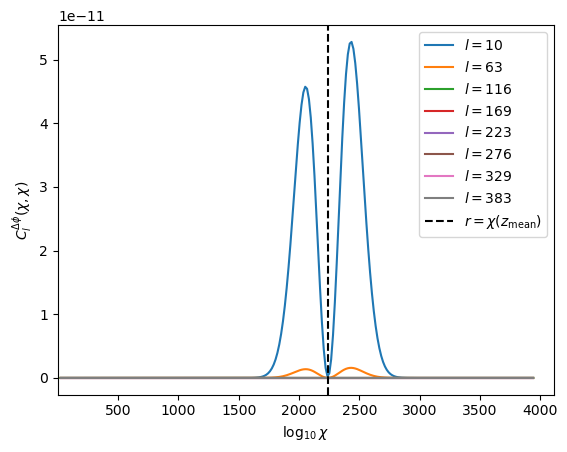

In [76]:
gc_auto.plot_Cl_DeltaP_of_chi()

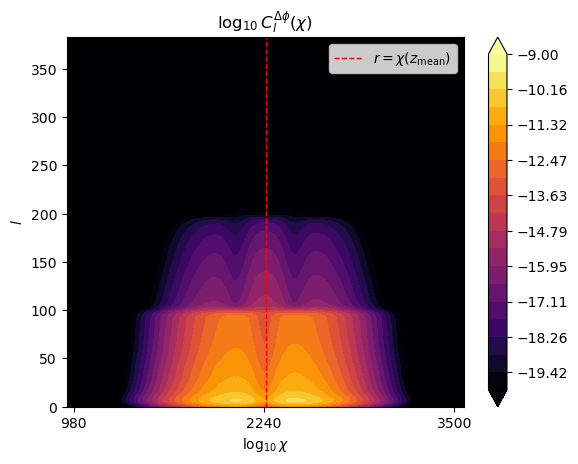

In [77]:
gc_auto.plot_Cl_DeltaP_of_chi_2D()

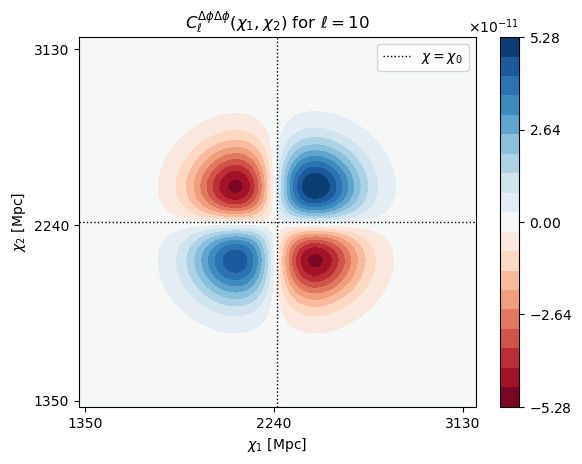

In [78]:
l = 10

gc_auto.plot_Cl_DeltaP_vs_chi_chiprime_2D(l)